# Data Imformation

The scallop data is downloaded from http://matt-wand.utsacademics.info/webspr/scallop.html. It records 148 triplets concerning scallop abundance based on a 1990 survey cruise in the Atlantic continental shelf off Long Island, New York, U.S.A. It has 3 columns: longitude, latitude and tot.catch.

In [1]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt
from plotters import plot_gp_2D
from data_preprocess import preprocess
import pymc3 as pm
from model import GP_model
scallop = pd.read_csv("data/scallop.csv", usecols = ["latitude", "longitude","tot.catch"])
scallop.head()

,latitude,longitude,tot.catch
0,40.55000,-71.55000,0
1,40.46667,-71.51667,0
2,40.51667,-71.71667,0
3,40.38333,-71.85000,1
4,40.31667,-71.78333,0


# Data Preprocessing

Data Preprocessing contains two parts: 

1. Apply log transformation to the response variable "tot.catch"
2. Split the data into train set and testing set. Unlike tranditional way of randomly splitting dataset (splitting by points), I evenly divided the map into blocks, and grouped the data (splitting by area). There are totally 41 groups. Then, I randomly chose 0.8 precent of groups as my training data. 

In [2]:
data = scallop.copy()
data["tot.catch"] = np.log(scallop["tot.catch"] + 1)


In [3]:
random.seed(0)
scdata = preprocess(long_block_num = 10, lat_block_num = 10)

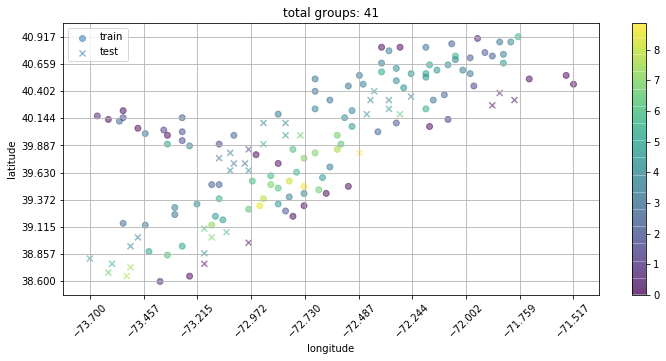

In [4]:
scdata.split_block_data(data, plot_block = True)

As you can see the picture above, the testing set is not so "closed" to the training set but also not too far way from it. In the real life, when you get some fish in one certain point, it is quite obvious that the point closed to it will also have fish. Therefore, we are more interested in the area nearby and never been explored. 

I also generate some data to have visualization

In [5]:
scdata.generate_posterior_plot_data()

In [6]:
gx, gy, X_new = scdata.generate_suface_data(lat = 40.144, long = -72.730)

# Gaussian Process

By the difinition given from the book, Gaussian Processes for Machine Learning, a Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.

A Gaussian process is completely specified by its mean function and covariance function. We define mean function m(x) and the covariance function k(x,x′) of a real process f(x) as

<center>m(x) = E[f(x)],
<center>k(x,x′) = E[(f(x)−m(x))(f(x′)−m(x′))],

and will write the Gaussian process as
􏰂<center>f(x) ∼ GP(m(x),k(x,x))

The posterior mean and covariance are:
<center>$mean = K(X_s,X)[K(X,X) + \sigma^2 *I]^{-1}y$
<center>$cov = K(X_s,X_s) - K(X_s,X)[K(X,X) + \sigma^2 *I]^{-1} K(X,X_s)$



   

## Kernel
define the two dimentional Kernel Squared Exponential (SE):

<center>$kernel\_SE = \sigma_f^2 exp(-\frac{1}{2}\Sigma(\frac{x_{i,d} - x_{j,d}}{l_d})^2)$
 

## Hyperparameters
The hyperparameters we are interested in are $\sigma_n, l, \sigma_f$:
1. $\sigma_f$: the scale of the output values (the overall variance of the process).
2. l: the scale at which distances are measured among inputs (the distance from which on two points will be uncorrelated) 
3. $\sigma_n$: the noise

Define the prior of those three parameters (demonstrated by Stan tutorial) :\
https://mc-stan.org/docs/2_22/stan-users-guide/fit-gp-section.html#priors-gp.section
1. l ~ invGamma(5,5) (two dims)
2. sigma_f ~ Normal(0, 1)
3. sigma_n ~ Normal(0, 1)

Sampling by Nuts

In [7]:
scmodel = GP_model(dim = 2,x = scdata.X_2D_train, y = scdata.Y_2D_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_n, sigma_f, l]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 38 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
l[0]     0.624  0.211   0.264    0.997      0.005    0.004    1549.0  1549.0   
l[1]     0.779  0.337   0.266    1.330      0.008    0.006    1635.0  1635.0   
sigma_f  2.313  0.521   1.362    3.265      0.012    0.009    1741.0  1720.0   
sigma_n  1.837  0.182   1.499    2.192      0.005    0.004    1156.0  1156.0   

         ess_bulk  ess_tail  r_hat  
l[0]       1280.0    1000.0    1.0  
l[1]       1294.0     913.0    1.0  
sigma_f    1783.0    2459.0    1.0  
sigma_n    1307.0     877.0    1.0  


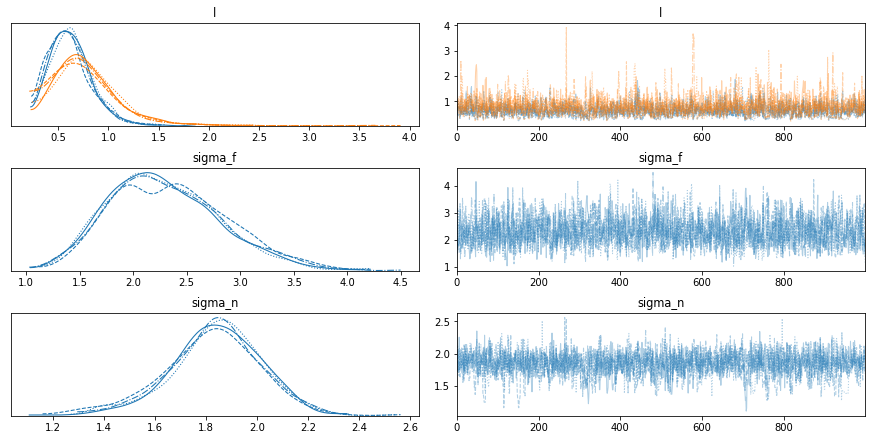

In [8]:
scmodel.train(niter = 1000)
scmodel.plot_trace()
scmodel.print_summary()

from the trace plot and R_hat from the summary, the sampling is reliable.

# Visualization

First, that's check the prediction on the whole plane, having some intuition about the prediction result

In [9]:
mu, sd,_ = scmodel.predict_GP(X_new, pred_noise = True,samples = 50, pred_name = "surface1")

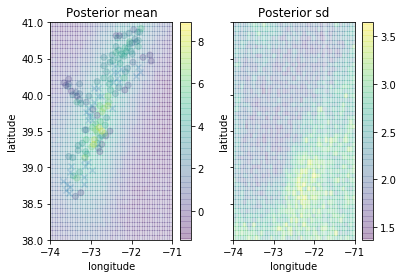

In [10]:
plot_gp_2D(gx, gy, mu,sd, scdata.X_2D_train, scdata.Y_2D_train, scdata.X_2D_test, scdata.X_2D_test, save_file = None)

From the plot, we can see that the area having more training data has less variance.

Then, that's have a closed look at the point (lat = 40.144, long = -72.730). In both of the direction, I plot the prediction with and without noise. The curves of prediction with noise are more smooth.

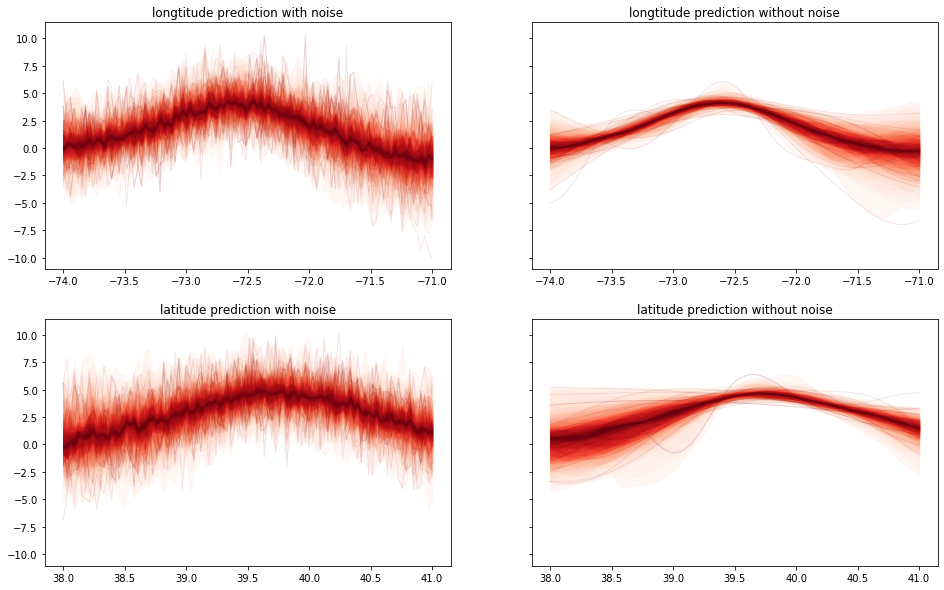

In [11]:
scmodel.plot_range(scdata.long_new, scdata.lat_new)

## Prediction result

In [12]:
mu, sd, scallop_samples = scmodel.predict_GP(scdata.X_2D_test, pred_noise = True,samples = 500, pred_name = "test")

In [13]:
def RMSE(y_pred, y_true):
    return np.sqrt(np.mean((np.exp(y_pred) - np.exp(y_true))**2))


In [14]:
RMSE(mu, scdata.Y_2D_test)

504.9266118612418